In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup 

import re
from nltk.corpus import stopwords 

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Data Loading

In [2]:
train_df = pd.read_csv('../input/news-summary/news_summary_more.csv')


In [3]:
train_df

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
...,...,...
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199..."
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...


# Preprocessing

In [4]:
#Contraction mapping
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [5]:
#get stopwords from NLTK
stop_words = set(stopwords.words('english')) 

#this function cleans the text
def text_cleaner(text):
    """
    This function cleanes the texts and returns the cleaned senctance.
    
    Input:
    text - Any string
    
    Output:
    Sentance - Cleaned string
    """
    
    newString = text.lower()
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
     
            
    return (" ".join(tokens)).strip()

In [6]:
#Applying the functions to clean each column

train_df.headlines = train_df.headlines.apply(text_cleaner)
train_df.text = train_df.text.apply(text_cleaner)

In [7]:
train_df

,headlines,text
0,upgrad learner switches career ml al salary hike,saurav kant alumnus upgrad iiit b pg program m...
1,delhi techie wins free food swiggy one year cred,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
4,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...
...,...,...
98396,crpf jawan axed death maoists chhattisgarh,crpf jawan tuesday axed death sharp edged weap...
98397,first song sonakshi sinha noor titled uff yeh,uff yeh first song sonakshi sinha starrer upco...
98398,matrix film get reboot reports,according reports new version science fiction ...
98399,snoop dogg aims gun clown dressed trump new video,new music video shows rapper snoop dogg aiming...


In [8]:
train_df.headlines = train_df.headlines.apply(lambda x : '_START_ '+ x + ' _END_')

# Tokenizing

In [9]:
#Distribution of words

text_count = []
summary_count = []

for sent in train_df.headlines:
    text_count.append(len(sent.split()))
    
for sent in train_df.text:
    summary_count.append(len(sent.split()))

graph_df = pd.DataFrame() 

graph_df['text'] = text_count
graph_df['summary'] = summary_count



In [10]:
graph_df.describe()

,text,summary
count,98401.000000,98401.000000
mean,9.201969,35.194713
std,1.189666,3.825659
min,3.000000,1.000000
25%,8.000000,33.000000
50%,9.000000,35.000000
75%,10.000000,38.000000
max,15.000000,60.000000


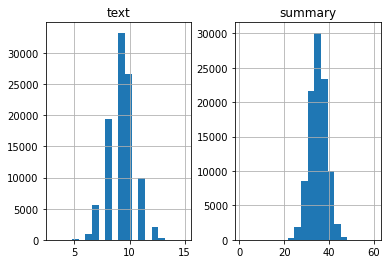

In [11]:
graph_df.hist(bins = 20)
plt.show()

In [12]:
# Maximum length for each input and target 
max_text_len = 46
max_summary_len = 15

In [13]:
#Train and test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df.text, train_df.headlines, test_size = 0.1, shuffle = True)

In [14]:
def sequence_tokenizer(train, test, max_len):
    """
    This function tokenizes and adds padding to a sequence of texts.
    
    Input:
    train - Train data which contains sentances.
    test - Test data, which also contains sentances.
    max_len - Argument to specify the maximum length for padding.
    
    Output:
    train - Toeknized train data
    test - Tokenized test data
    tokenizer - The tokenizer instance ( To invert back in the future )
    """
    
    #Initialize the tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train)
    
    #Texts to integer squences
    train = tokenizer.texts_to_sequences(train)
    test = tokenizer.texts_to_sequences(test)
    
    #Add padding
    train = pad_sequences(train, maxlen= max_len, padding = 'post')
    test = pad_sequences(test, maxlen= max_len, padding = 'post')
    
    return train, test, tokenizer
    

In [15]:
X_train, X_test, X_tokenizer = sequence_tokenizer(X_train, X_test, max_text_len)
y_train, y_test, y_tokenizer = sequence_tokenizer(y_train, y_test, max_summary_len)

In [16]:
#Number of words in the vocabulary and + 1 for padding 

x_voc = len(X_tokenizer.word_index) + 1
y_voc = len(y_tokenizer.word_index) + 1

In [17]:
print('Vocubulary size of Text: ', x_voc)
print('Vocubulary size of summary: ', y_voc)

Vocubulary size of Text:  73120
Vocubulary size of summary:  31263


# Model Building

In [18]:
latent_dim = 500
embedding_dim = 200

# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 46)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 46, 200)      14624000    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 46, 500), (N 1402000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [19]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

#Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [20]:
#Fitting the model
history = model.fit(
    [X_train, y_train[:, :-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:, 1:],
    epochs=35,
    callbacks=[es],
    batch_size=300,
    validation_data=([X_test, y_test[:, :-1]], y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[: , 1:]),
    )

Epoch 1/35
296/296 [==============================] - 253s 824ms/step - loss: 5.1501 - val_loss: 4.3079
Epoch 2/35
296/296 [==============================] - 243s 822ms/step - loss: 4.3682 - val_loss: 4.1346
Epoch 3/35
296/296 [==============================] - 244s 826ms/step - loss: 4.1595 - val_loss: 3.9254
Epoch 4/35
296/296 [==============================] - 243s 821ms/step - loss: 3.9135 - val_loss: 3.7241
Epoch 5/35
296/296 [==============================] - 246s 830ms/step - loss: 3.6721 - val_loss: 3.5658
Epoch 6/35
296/296 [==============================] - 245s 828ms/step - loss: 3.4745 - val_loss: 3.4526
Epoch 7/35
296/296 [==============================] - 247s 833ms/step - loss: 3.3115 - val_loss: 3.3340
Epoch 8/35
296/296 [==============================] - 248s 836ms/step - loss: 3.1742 - val_loss: 3.2609
Epoch 9/35
296/296 [==============================] - 246s 833ms/step - loss: 3.0468 - val_loss: 3.2003
Epoch 10/35
296/296 [==============================] - 247s 834m

In [21]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = X_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [22]:
# Inference Models

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [23]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'end':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'end' or len(decoded_sentence.split()) \
            >= max_summary_len - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [24]:
# To convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['start'] and i != target_word_index['end']:
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

In [25]:
for i in range(0, 19):
    print ('Review:', seq2text(X_train[i]))
    print ('Original summary:', seq2summary(y_train[i]))
    print ('Predicted summary:', decode_sequence(X_train[i].reshape(1,
           max_text_len)))
    print('\n')

Review: bihar cm nitish kumar saturday attended wedding rjd supremo lalu prasad yadav son tej pratap almost nine months ending grand alliance forming government bjp lalu younger son tejashwi deputy cm kumar former government tej served health minister deputy cm sushil kumar modi also reportedly invited wedding 
Original summary: nitish lalu son wedding months ending alliance 
Predicted summary:  lalu son tej pratap yadav daughter tej pratap


Review: yoga guru baba ramdev said patanjali ayurved finish multinational firms indian market next five years ramdev said mncs working country development rather sole objective loot india five years patanjali would educate farmers latest techniques also offer decent prices added 
Original summary: patanjali finish multinationals india yrs ramdev 
Predicted summary:  patanjali india largest ramdev patanjali md


Review: aviation regulator dgca asked airlines direct pilots make announcements important monuments sites like taj mahal statue unity ajan